### Importación de los datasets y funciones

In [1]:
import glob
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report,confusion_matrix

def recortar(pix,imagenes):##Función para recortar pixeles a cada lado deseados de las imagenes
    a = (pix*2)+1
    for i in range(2,a,2):
        imagenes = np.delete(imagenes,0,axis=1)
        imagenes = np.delete(imagenes,64-i,axis=1)
        imagenes = np.delete(imagenes,0,axis=2)
        imagenes = np.delete(imagenes,64-i,axis=2)
        
    return imagenes

data = np.array([ np.array(PIL.Image.open(f).convert("RGB")).ravel() 
                  for f in glob.glob("D:/SKINS PROJECT/IMAGEN_64_10015/*.jpg") ]) #Ponemos la carpeta seguida de *
                                                  #para que seleccione todos los archivos
metadata = pd.read_csv("D:/SKINS PROJECT/HAM10000_metadata.csv")
index = np.arange(24306,34321)
index.shape
metadata[metadata['image_id']=='ISIC_0024309']
pix = 3
h = (64-(pix+pix))*(64-(pix+pix))
dfimg = pd.DataFrame(data=data[0:,0:],index=index[0:])

img64 = dfimg.values.reshape(-1,64,64,3)
img60 = recortar(pix,img64)
img60 = img60.reshape(-1,h*3)
dfimg60 = pd.DataFrame(img60[0:,0:],index=index[0:])
dfimg60['lesion']=0
for i in range(10015):
    lin_isc = 'ISIC_00' + str(i+24306)

    location = metadata[metadata['image_id']==lin_isc].index.item()

    dfimg60.loc[i+24306,'lesion'] = metadata.loc[location,'dx']
dfimg60['nv']=0
dfimg60['mel']=0
dfimg60['bkl']=0
dfimg60['bcc']=0
dfimg60['akiec']=0
dfimg60['vasc']=0
dfimg60['df']=0
for i in range(10015):
    les = dfimg60.loc[i+24306,'lesion']
    dfimg60.loc[i+24306,les] = 1

del dfimg60['lesion']
dfimg60_copia_nv = dfimg60
dfimg60_copia_mel = dfimg60
dfimg60_copia_bkl = dfimg60
dfimg60_copia_bcc = dfimg60
dfimg60_copia_akiec = dfimg60
dfimg60_copia_vasc = dfimg60
dfimg60_copia_df = dfimg60

### Estudios modelos dicotómicos para cada una de las clases

La idea de este apartado será estudiar si se puede conseguir un modelo que sea capaz de predecir una clase de mancha de la piel en concreto respecto del resto. La idea es que si esto se consiguiese, sería entonces momento de montar un algoritmo que elija la clase más votada de todos los modelos anteriores:

In [2]:
##NV

In [3]:
dfimg60_copia_nv = dfimg60_copia_nv.drop(['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df'], axis=1)
x_dfimg = dfimg60_copia_nv.iloc[:,:dfimg60_copia_nv.shape[1]-1]

y_dfimg = dfimg60_copia_nv.iloc[:,dfimg60_copia_nv.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(x_dfimg, y_dfimg, test_size=0.3, random_state=42)
img_rows, img_cols = 58, 58
input_shape = (img_rows, img_cols, 3)

x_train = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 3)
y_train = y_train.values.reshape(y_train.shape[0],)
y_test = y_test.values.reshape(y_test.shape[0],)
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean)/std
x_test = (x_test-mean)/std

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(58,58,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=256, epochs=8, validation_split=0.3 )
hist_nv = hist
model_nv = model

Using TensorFlow backend.




Train on 4907 samples, validate on 2103 samples
Epoch 1/8
4907/4907 [==============================] - 31s 6ms/step - loss: 0.8794 - accuracy: 0.6267 - val_loss: 0.5892 - val_accuracy: 0.6648
Epoch 2/8
4907/4907 [==============================] - 27s 6ms/step - loss: 0.5380 - accuracy: 0.7145 - val_loss: 0.5102 - val_accuracy: 0.7309
Epoch 3/8
4907/4907 [==============================] - 27s 6ms/step - loss: 0.4693 - accuracy: 0.7711 - val_loss: 0.4612 - val_accuracy: 0.7722
Epoch 4/8
4907/4907 [==============================] - 27s 5ms/step - loss: 0.4331 - accuracy: 0.7887 - val_loss: 0.4522 - val_accuracy: 0.7917
Epoch 5/8
4907/4907 [==============================] - 27s 5ms/step - loss: 0.4061 - accuracy: 0.8103 - val_loss: 0.4408 - val_accuracy: 0.7922
Epoch 6/8
4907/4907 [==============================] - 27s 6ms/step - loss: 0.3906 - accuracy: 0.8180 - val_loss: 0.4196 - val_accuracy: 0.8008
Epoch 7/8
4907/4907 [==============================] - 27s 5ms/step - loss: 0.3725 - a

In [4]:
##MEL

In [5]:
dfimg60_copia_mel = dfimg60_copia_mel.drop(['nv', 'bkl', 'bcc', 'akiec', 'vasc', 'df'], axis=1)
x_dfimg = dfimg60_copia_mel.iloc[:,:dfimg60_copia_mel.shape[1]-1]

y_dfimg = dfimg60_copia_mel.iloc[:,dfimg60_copia_mel.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(x_dfimg, y_dfimg, test_size=0.3, random_state=42)
img_rows, img_cols = 58, 58
input_shape = (img_rows, img_cols, 3)

x_train = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 3)
y_train = y_train.values.reshape(y_train.shape[0],)
y_test = y_test.values.reshape(y_test.shape[0],)
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean)/std
x_test = (x_test-mean)/std

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(58,58,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=256, epochs=8, validation_split=0.3 )
hist_mel = hist
model_mel = model

Train on 4907 samples, validate on 2103 samples
Epoch 1/8
4907/4907 [==============================] - 28s 6ms/step - loss: 0.6584 - accuracy: 0.8908 - val_loss: 0.3135 - val_accuracy: 0.8944
Epoch 2/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.3182 - accuracy: 0.8908 - val_loss: 0.3041 - val_accuracy: 0.8944
Epoch 3/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.3151 - accuracy: 0.8908 - val_loss: 0.3141 - val_accuracy: 0.8944
Epoch 4/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.3113 - accuracy: 0.8908 - val_loss: 0.3115 - val_accuracy: 0.8944
Epoch 5/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.3042 - accuracy: 0.8908 - val_loss: 0.2997 - val_accuracy: 0.8944
Epoch 6/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.2954 - accuracy: 0.8908 - val_loss: 0.2973 - val_accuracy: 0.8944
Epoch 7/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.2936 - acc

In [6]:
##bkl

In [7]:
dfimg60_copia_bkl =dfimg60_copia_bkl.drop(['mel', 'nv', 'bcc', 'akiec', 'vasc', 'df'], axis=1)
x_dfimg = dfimg60_copia_bkl.iloc[:,:dfimg60_copia_bkl.shape[1]-1]

y_dfimg = dfimg60_copia_bkl.iloc[:,dfimg60_copia_bkl.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(x_dfimg, y_dfimg, test_size=0.3, random_state=42)
img_rows, img_cols = 58, 58
input_shape = (img_rows, img_cols, 3)

x_train = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 3)
y_train = y_train.values.reshape(y_train.shape[0],)
y_test = y_test.values.reshape(y_test.shape[0],)
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean)/std
x_test = (x_test-mean)/std

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(58,58,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=256, epochs=8, validation_split=0.3 )
hist_bkl = hist
model_bkl = model

Train on 4907 samples, validate on 2103 samples
Epoch 1/8
4907/4907 [==============================] - 28s 6ms/step - loss: 0.4990 - accuracy: 0.8761 - val_loss: 0.3433 - val_accuracy: 0.8849
Epoch 2/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.3110 - accuracy: 0.8897 - val_loss: 0.3392 - val_accuracy: 0.8840
Epoch 3/8
4907/4907 [==============================] - 27s 5ms/step - loss: 0.3040 - accuracy: 0.8902 - val_loss: 0.3223 - val_accuracy: 0.8849
Epoch 4/8
4907/4907 [==============================] - 27s 5ms/step - loss: 0.2925 - accuracy: 0.8910 - val_loss: 0.3253 - val_accuracy: 0.8849
Epoch 5/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.2849 - accuracy: 0.8912 - val_loss: 0.3092 - val_accuracy: 0.8849
Epoch 6/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.2923 - accuracy: 0.8910 - val_loss: 0.3099 - val_accuracy: 0.8859
Epoch 7/8
4907/4907 [==============================] - 26s 5ms/step - loss: 0.2761 - acc

In [8]:
#bcc

In [9]:
dfimg60_copia_bcc = dfimg60_copia_bcc.drop(['mel', 'bkl', 'nv', 'akiec', 'vasc', 'df'], axis=1)
x_dfimg = dfimg60_copia_bcc.iloc[:,:dfimg60_copia_bcc.shape[1]-1]

y_dfimg = dfimg60_copia_bcc.iloc[:,dfimg60_copia_bcc.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(x_dfimg, y_dfimg, test_size=0.3, random_state=42)
img_rows, img_cols = 58, 58
input_shape = (img_rows, img_cols, 3)

x_train = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 3)
y_train = y_train.values.reshape(y_train.shape[0],)
y_test = y_test.values.reshape(y_test.shape[0],)
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean)/std
x_test = (x_test-mean)/std

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(58,58,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=256, epochs=8, validation_split=0.3 )
hist_bcc = hist
model_bcc = model

Train on 4907 samples, validate on 2103 samples
Epoch 1/8
4907/4907 [==============================] - 42s 9ms/step - loss: 0.3498 - accuracy: 0.9305 - val_loss: 0.1603 - val_accuracy: 0.9534
Epoch 2/8
4907/4907 [==============================] - 39s 8ms/step - loss: 0.1657 - accuracy: 0.9462 - val_loss: 0.1498 - val_accuracy: 0.9534
Epoch 3/8
4907/4907 [==============================] - 41s 8ms/step - loss: 0.1571 - accuracy: 0.9462 - val_loss: 0.1441 - val_accuracy: 0.9534
Epoch 4/8
4907/4907 [==============================] - 44s 9ms/step - loss: 0.1549 - accuracy: 0.9462 - val_loss: 0.1439 - val_accuracy: 0.9534
Epoch 5/8
4907/4907 [==============================] - 42s 9ms/step - loss: 0.1468 - accuracy: 0.9460 - val_loss: 0.1480 - val_accuracy: 0.9524
Epoch 6/8
4907/4907 [==============================] - 38s 8ms/step - loss: 0.1528 - accuracy: 0.9454 - val_loss: 0.1504 - val_accuracy: 0.9505
Epoch 7/8
4907/4907 [==============================] - 41s 8ms/step - loss: 0.1426 - acc

In [ ]:
#vasc

In [ ]:
dfimg60_copia_vasc = dfimg60_copia_vasc.drop(['mel', 'bkl', 'bcc', 'akiec', 'nv', 'df'], axis=1)
x_dfimg = dfimg60_copia_vasc.iloc[:,:dfimg60_copia_vasc.shape[1]-1]

y_dfimg = dfimg60_copia_vasc.iloc[:,dfimg60_copia_vasc.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(x_dfimg, y_dfimg, test_size=0.3, random_state=42)
img_rows, img_cols = 58, 58
input_shape = (img_rows, img_cols, 3)

x_train = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 3)
y_train = y_train.values.reshape(y_train.shape[0],)
y_test = y_test.values.reshape(y_test.shape[0],)
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean)/std
x_test = (x_test-mean)/std

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(58,58,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=256, epochs=8, validation_split=0.3 )
hist_vasc = hist
model_vasc = model

In [ ]:
#df

In [ ]:
dfimg60_copia_df = dfimg60_copia_df.drop(['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'nv'], axis=1)
x_dfimg = dfimg60_copia_df.iloc[:,:dfimg60_copia_df.shape[1]-1]

y_dfimg = dfimg60_copia_df.iloc[:,dfimg60_copia_df.shape[1]-1]
x_train, x_test, y_train, y_test = train_test_split(x_dfimg, y_dfimg, test_size=0.3, random_state=42)
img_rows, img_cols = 58, 58
input_shape = (img_rows, img_cols, 3)

x_train = x_train.values.reshape(x_train.shape[0], img_rows, img_cols, 3)
x_test = x_test.values.reshape(x_test.shape[0], img_rows, img_cols, 3)
y_train = y_train.values.reshape(y_train.shape[0],)
y_test = y_test.values.reshape(y_test.shape[0],)
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)
mean = x_train.mean()
std = x_train.std()

x_train = (x_train-mean)/std
x_test = (x_test-mean)/std

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(58,58,3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(1000, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
hist = model.fit(x_train, y_train_one_hot, 
           batch_size=256, epochs=8, validation_split=0.3 )
hist_df = hist
model_df = model

Tras entrenar por separado todos los modelos, se aprecia que el único que actua aceptablemente por separado es el caso de nv. Por ello, vamos a incidir a estudiar en este apartado el caso nv frente al resto:

Mayor probabilidad: nv 72.0 %
Menor probabilidad: no nv 28.0 %


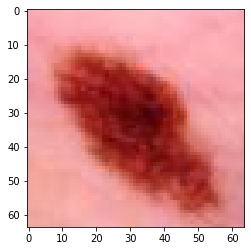

In [8]:

my_image = plt.imread("D:/SKINS PROJECT/IMAGEN_64_10015/ISIC64_0024308.jpg")
from skimage.transform import resize
my_image_resized = resize(my_image, (58,58,3))

mean_resized = my_image_resized.mean()
std_resized = my_image_resized.std()

my_image_resized = (my_image_resized-mean_resized)/std_resized



img = plt.imshow(my_image)
import numpy as np
probabilities_nv = model_nv.predict(np.array( [my_image_resized,] ))
number_to_class = ['no nv', 'nv']
index = np.argsort(probabilities_nv[0,:])
print("Mayor probabilidad:", number_to_class[index[1]], round(100*probabilities_nv[0,index[1]],2),'%')
print("Menor probabilidad:", number_to_class[index[0]], round(100*probabilities_nv[0,index[0]],2),'%')

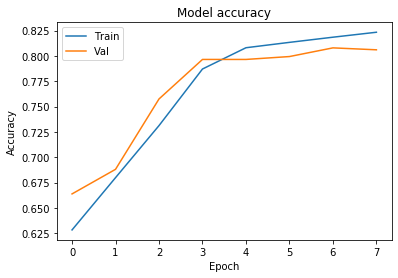

In [4]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [6]:
model_nv.evaluate(x_test, y_test_one_hot)[1]

3005/3005 [==============================] - 12s 4ms/step


0.8039933443069458

In [ ]:
print("Tipo más probable:", number_to_class[index[1]], round(100*probabilities[0,index[1]],2),'%')
print("Segundo tipo más probable:", number_to_class[index[0]], round(100*probabilities[0,index[0]],2),'%')